# Changepoint detection and deviation detection
Notebook containing experimental evaluation of deviation detection methods.

In [1]:
import numpy as np
import os, sys
import math
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
%matplotlib inline 
#from my_functions import *
from modules.preprocessing import *
#from modules.statistics import *
from modules.learning import *
from scipy import stats
from ast import literal_eval
from modules.experiments import *
import matplotlib.dates as mdates


## Read data
Read input time series. Manual washing dates are given as input. 

In [2]:
file_arrays = "/data/data2/inaccess/extracted_data/arrays.csv"
file_arrays_day = "/data/data2/inaccess/extracted_data/arrays_per_day.csv"
file_weather = "/data/data2/inaccess/extracted_data/weather.csv"
file_expected = "/data/data2/inaccess/extracted_data/expected_power.csv"

no_arrays = 14
dates_wash_start = pd.to_datetime(pd.Series(['2021-04-15 00:00:00', '2020-10-22 00:00:00', '2020-06-01 00:00:00', '2019-07-25 00:00:00', '2019-05-22 00:00:00', '2018-09-02 00:00:00', '2018-05-31 00:00:00', '2017-05-12 00:00:00', '2016-10-17 00:00:00', '2016-07-30 00:00:00', '2016-06-25 00:00:00', '2015-06-25 00:00:00', '2015-08-03 00:00:00', '2014-08-06 00:00:00', '2014-06-02 00:00:00']))
dates_wash_stop = pd.to_datetime(pd.Series(['2021-04-19 00:00:00', '2020-10-26 00:00:00', '2020-06-05 00:00:00', '2019-07-29 00:00:00', '2019-05-26 00:00:00', '2018-09-06 00:00:00', '2018-06-04 00:00:00', '2017-05-16 00:00:00', '2016-10-21 00:00:00', '2016-08-03 00:00:00', '2016-06-29 00:00:00', '2015-06-29 00:00:00', '2015-08-07 00:00:00', '2014-08-10 00:00:00', '2014-06-06 00:00:00']))

scaler = MinMaxScaler()
df_weather = pd.read_csv(file_weather).set_index('measurement_time')
df_weather = df_weather.rename_axis('timestamp')
df_weather.index = pd.to_datetime(df_weather.index)
df_weather = df_weather.iloc[: , :-1]
df_weather.columns = [ 'mean_irradiance','air_temp', 'mean_mod_temp', 'precipitation', 'humidity', 'wind_dir', 'wind_speed']
df_weather_clean = df_weather.dropna(subset=['precipitation']).copy().sort_index()
#df_weather_clean.head()
df_weather_scaled = pd.DataFrame(scaler.fit_transform(df_weather_clean), columns=df_weather_clean.columns, index=df_weather_clean.index)
df_weather_scaled.head()

,mean_irradiance,air_temp,mean_mod_temp,precipitation,humidity,wind_dir,wind_speed
timestamp,,,,,,,
2014-01-01 00:00:00,0.005383,0.515894,0.240814,9.275331e-10,0.854536,0.279050,2.613575e-07
2014-01-01 00:15:00,0.006296,0.518888,0.238498,2.318799e-09,0.874373,0.270916,2.749406e-07
2014-01-01 00:30:00,0.012483,0.516374,0.237450,3.478352e-09,0.885812,0.258940,3.040241e-07
2014-01-01 00:45:00,0.017354,0.514967,0.236895,4.405853e-09,0.885461,0.261322,3.053200e-07
2014-01-01 01:00:00,0.022735,0.515866,0.235946,6.029187e-09,0.894617,0.242502,3.601820e-07


In [3]:
df_arrays = pd.read_csv(file_arrays).set_index('measurement_time')
df_arrays = df_arrays.rename_axis('timestamp')
df_arrays.columns = [ 'array_name', 'mod_temp', 'power', 'irradiance']
df_arrays.index = pd.to_datetime(df_arrays.index)
#df_arrays = df_arrays.between_time(start, end)#.dropna()
df_grouped_arrays = [x for _, x in df_arrays.groupby(['array_name'],sort=True)]
dict_arrays = {}
dict_scaled_arrays = {}
scaler = MinMaxScaler()
for df_one_array in df_grouped_arrays:
    key = df_one_array.array_name[0]
    df_new_array = df_one_array[['mod_temp', 'power', 'irradiance']]#.join(df_weather_clean)
    #print(f'Irradiance: mean: {np.mean(df_new_array.irradiance)}, variance: {np.var(df_new_array.irradiance)}, standard deviation: {np.sqrt(np.var(df_new_array.irradiance))}')
    #filter irradiance:
    #df_new_array = df_new_array[df_new_array.irradiance>500]
    df_new_array = df_new_array.rolling('2s').mean().dropna()
    df_new_array = pd.DataFrame(scaler.fit_transform(df_new_array), columns=df_new_array.columns, index=df_new_array.index)
    df_new_array = df_new_array.join(df_weather_scaled)
    df_new_array.index = df_new_array.index.round(freq = '15T')
    dict_scaled_arrays[key] = df_new_array.interpolate() #dict_arrays[key]



In [4]:
#df = dict_scaled_arrays['Array 4'].join(df_weather_clean)   
df_scaled = dict_scaled_arrays['Array 4']
df = df_scaled[['mod_temp', 'power', 'irradiance']].join(df_weather_clean)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

### Remove aging effect

In [5]:
# for Inaccess data:
aging_by_year = np.array([2.5, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]) / 100
op_years = [('2014-01-01 00:00:00', '2015-01-01 00:00:00'),('2015-01-01 00:00:00', '2016-01-01 00:00:00'),('2016-01-01 00:00:00', '2017-01-01 00:00:00'),('2017-01-01 00:00:00', '2018-01-01 00:00:00'),('2018-01-01 00:00:00', '2019-01-01 00:00:00'),
('2019-01-01 00:00:00', '2020-01-01 00:00:00'),
('2020-01-01 00:00:00', '2021-01-01 00:00:00'),
('2021-01-01 00:00:00', '2022-01-01 00:00:00')]

#for j in range(no_arrays):
df_coefs = pd.DataFrame(columns=['coef'], index=df_scaled.index)
prev_factor = 1
for i, (start, end) in enumerate(op_years):
    factor = aging_by_year[i]
    c = np.linspace(prev_factor, prev_factor + factor, df_coefs[start:end].values.shape[0])
    df_coefs['coef'][start:end] = c
    prev_factor = prev_factor + factor
#dict_scaled_arrays['Array '+str(j+1)]['normalized_power'] = dict_scaled_arrays['Array '+str(j+1)].normalized_power * df_coefs.coef
df_scaled['normalized_power'] = df_scaled.power * df_coefs.coef

#df_coefs.plot()

In [6]:
df_scaled = df_scaled['2015':'2020']
df = df['2015':'2020'] 
start = '11:00'
end = '16:00'
df_scaled = df_scaled.between_time(start, end)

In [7]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45003 entries, 2015-01-01 11:00:00 to 2020-12-31 16:00:00
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mod_temp          45003 non-null  float64
 1   power             45003 non-null  float64
 2   irradiance        45003 non-null  float64
 3   mean_irradiance   44998 non-null  float64
 4   air_temp          44997 non-null  float64
 5   mean_mod_temp     44998 non-null  float64
 6   precipitation     44999 non-null  float64
 7   humidity          44997 non-null  float64
 8   wind_dir          44996 non-null  float64
 9   wind_speed        44995 non-null  float64
 10  normalized_power  45003 non-null  object 
dtypes: float64(10), object(1)
memory usage: 4.1+ MB


In [8]:
df_scaled.describe()

,mod_temp,power,irradiance,mean_irradiance,air_temp,mean_mod_temp,precipitation,humidity,wind_dir,wind_speed
count,45003.000000,45003.000000,45003.000000,44998.000000,44997.000000,44998.000000,4.499900e+04,44997.000000,44996.000000,4.499500e+04
mean,0.516605,0.398181,0.369856,0.369865,0.486603,0.516613,1.193938e-09,0.679336,0.623940,3.926396e-07
std,0.154167,0.264361,0.252192,0.252203,0.145121,0.154173,5.254636e-09,0.183314,0.172147,1.741658e-07
min,0.081631,0.000000,0.000000,0.000000,0.073771,0.081631,0.000000e+00,0.006746,0.076051,0.000000e+00
25%,0.394559,0.155757,0.143207,0.143198,0.371304,0.394554,0.000000e+00,0.551351,0.561598,2.773954e-07
50%,0.517333,0.391061,0.349001,0.349003,0.472556,0.517339,0.000000e+00,0.684118,0.688097,3.943403e-07
75%,0.635936,0.643859,0.594493,0.594526,0.610002,0.635950,0.000000e+00,0.823196,0.752898,5.014991e-07
max,0.993335,1.000000,1.000000,1.000000,0.948477,0.993335,1.089760e-07,0.998431,0.919492,8.240547e-06


## Extract rains
Use precipitation values to extract rains. Each rain corresponds to a maximal period of positive precipitation.

In [9]:
if df.precipitation.iloc[0]>0:
    precipitation = pd.concat([pd.Series({min(df.index)-pd.Timedelta('1s'): 0}),df.precipitation])
else:
    precipitation = df.precipitation

precipitation.index = pd.to_datetime(precipitation.index)
df_dates = pd.DataFrame(index = precipitation.index)
df_dates["rain_start"] = precipitation[(precipitation.shift(-1) > 0) & (precipitation == 0)] # compare current to next
df_dates["rain_stop"] = precipitation[(precipitation.shift(1) > 0) & (precipitation == 0)] # compare current to prev
dates_rain_start = pd.Series(df_dates.rain_start.index[df_dates.rain_start.notna()])
dates_rain_stop = pd.Series(df_dates.rain_stop.index[df_dates.rain_stop.notna()])

Number of rains:

In [10]:
dates_rain_stop.shape[0]

608

### Filter out light rains
Any rain with maximum precipitation less than x is considered light.

In [11]:
x = 0.9
ids = []
for idx in range(dates_rain_start.size):
    d1 = dates_rain_start[idx]
    d2 = dates_rain_stop[idx]
    if np.max(precipitation.loc[d1:d2]) >= x:
        ids.append(idx)
dates_rain_start_filtered = dates_rain_start[ids]
dates_rain_stop_filtered = dates_rain_stop[ids]

Number of remaining rains:

In [12]:
dates_rain_stop_filtered.shape[0]

32

### Regression model trained after manual cleanings 
Train a regression model on periods of w_train days after the manual washings of the panels.

In [13]:
w_train = 30
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
ref_points2 = pd.Index(dates_wash_stop)
model2, training_error2, validation_error2 = train_on_reference_points(df_scaled, w_train, ref_points2, feats, target)
validation_error2

Training Metrics:
MAE:0.017 
ME(true-pred):0.000 
MAPE:0.035 
R2: 0.985

Validation Metrics:
MAE:0.018 
ME(true-pred):-0.001 
MAPE:0.037 
MPE:-0.002 
R2: 0.982



array([ 9.81893447e-01,  1.84855641e-02, -8.97130643e-04,  3.74524628e-02,
       -1.81762114e-03, -3.81121696e-03])

## Detect changepoints

Two methods for detecting changepoints. 
Method 1. For each rain (or manual cleaning), we train and validate a regression model in the time period right before it, and we test it in the time period right after it. We then employ a score function which ranks preferably those rains with a small error before them and a large error after them. 
Method 2. We use the model trained on periods succeeding manual cleanings. For each rain (or manual cleaning), we measure the prediction error in the time period right before it, and the prediction error in the time period right after it. We then employ a score function which ranks preferably those rains with a large error before them and a small error after them.

### Initialize parameters

In [14]:
w1 = 10  # window of days to train (before the rain)
w2 = 5 # window of days to validate (before the rain)
w3 = 10 # window of days to test (after the rain)

error_br_column = 5 #0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe, 5=median error
error_ar_column = 5
thrsh = 1

In [15]:
errors_br1 = np.empty((dates_rain_start_filtered.size, 6))
errors_ar1 = np.empty((dates_rain_start_filtered.size, 6))
scores = np.empty((dates_rain_start_filtered.size))
indices = np.empty(len(scores), dtype=int)
error_names = {0: "r_squared", 1: "MAE", 2: "ME (true-pred)", 3: "MAPE", 4: "MPE (true-pred)", 5: "Median error"}

### Detect changepoints

In [16]:
p_changepoints_start = (pd.Series(dates_rain_start_filtered.tolist() + dates_wash_start.tolist()).sort_values())
p_changepoints_stop = (pd.Series(dates_rain_stop_filtered.tolist() + dates_wash_stop.tolist()).sort_values())
target = 'normalized_power'
feats = ['irradiance', 'mod_temp']
error_name_br = error_names[error_br_column] 
error_name_ar = error_names[error_ar_column]

#compute errors using one model per rain
errors_br1, errors_ar1 = calc_changepoints_many_models(df_scaled, p_changepoints_start, p_changepoints_stop, target, feats, w1, w2, w3 )
errors_br2, errors_ar2 = calc_changepoints_one_model(df_scaled, p_changepoints_start, p_changepoints_stop, model2, target, feats, 5, 10)

#set threshold on MAPE error before rain
mask1 = (errors_br1[:,3]<= 0.05)
mask2 = (errors_ar2[:,3]<= 0.05)

#compute scores for the remaining
scores1 = -(errors_br1[:, error_br_column]-errors_ar1[:, error_ar_column])/np.abs(errors_br1[:, error_ar_column])
scores1[(~mask1)] = np.finfo('d').min

scores2 = -(errors_br2[:, error_br_column]-errors_ar2[:, error_ar_column])/np.abs(errors_ar2[:, error_ar_column])
scores2[(~mask2)] = np.finfo('d').min


#sort
indices1 = np.argsort(-scores1)
indices2 = np.argsort(-scores2)

#compute final output
precip = df.precipitation
df_events_output1=pd.DataFrame(output_changepoints(scores1, indices1, p_changepoints_start, p_changepoints_stop, errors_br1[:, error_br_column], errors_ar1[:, error_ar_column], error_name_br, error_name_ar, precip))
df_events_output2=pd.DataFrame(output_changepoints(scores2, indices2, p_changepoints_start, p_changepoints_stop, errors_br2[:, error_br_column], errors_ar2[:, error_ar_column], error_name_br, error_name_ar, precip))

# effective changepoints = the ones with score at least thrsh  
mask1 = (df_events_output1['Score']>thrsh)
mask2 = (df_events_output2['Score']>thrsh)

effective_cp1 = df_events_output1[mask1]["id"].values 
effective_cp2 = df_events_output2[mask2]["id"].values 

print(f'Number of "effective" changepoints using Method 1: {len(set(effective_cp1))}') 
print(f'Number of "effective" changepoints using Method 2: {len(set(effective_cp2))}') 



Number of "effective" changepoints using Method 1: 11
Number of "effective" changepoints using Method 2: 7


### Train model after changepoints computed by Method 1

In [17]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)]))
model1, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.017 
ME(true-pred):0.000 
MAPE:0.045 
R2: 0.987

Validation Metrics:
MAE:0.018 
ME(true-pred):0.001 
MAPE:0.047 
MPE:0.001 
R2: 0.985



array([ 9.84818788e-01,  1.79980237e-02,  5.37395606e-04,  4.68302315e-02,
        1.39828467e-03, -1.71060076e-03])

### Train model after changepoints computed by Method 2

In [18]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)]))
model3, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.011 
ME(true-pred):-0.000 
MAPE:0.032 
R2: 0.994

Validation Metrics:
MAE:0.011 
ME(true-pred):0.000 
MAPE:0.031 
MPE:0.000 
R2: 0.994



array([9.93964507e-01, 1.07776465e-02, 4.36833240e-05, 3.09351181e-02,
       1.25384404e-04, 1.33075045e-03])

## Segmentation using changepoints obtained by Method 1

In [19]:
dates_changepoints = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp1)])
dates_start = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_stop = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_start = dates_start.union([max(df.index)])
dates_stop = dates_stop.union([min(df.index)])

### Assign scores to segments using model trained after changepoints
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after changepoints obtained by Method 1. 

In [20]:
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
slopes = []
mpe_scores = []
sign_slopes = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model1, feats, target)
        mpe_scores.append(st.score_segment(df_scaled.loc[d1:d2].normalized_power, y_pred)[0])
        diff = (df_scaled.loc[d1:d2].normalized_power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        slopes.append(-slope)
        sign_slopes.append(np.sign(-slope))
    except:
        sign_slopes.append(np.finfo('d').min)
        slopes.append(np.finfo('d').min)
        mpe_scores.append(1)

In [21]:
#debugging
d2 = dates_start[1]
d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
df_scaled.loc[d1:d2]

,mod_temp,power,irradiance,mean_irradiance,air_temp,mean_mod_temp,precipitation,humidity,wind_dir,wind_speed,normalized_power
timestamp,,,,,,,,,,,
2015-01-25 11:00:00,0.431234,0.287288,0.246700,0.246700,0.344425,0.431234,0.0,0.592483,0.749348,1.683698e-07,0.294608
2015-01-25 11:15:00,0.421680,0.379917,0.322498,0.322498,0.343839,0.421680,0.0,0.582272,0.741903,1.942284e-07,0.389598
2015-01-25 11:30:00,0.439299,0.353379,0.300516,0.300516,0.344090,0.439299,0.0,0.587430,0.700699,2.048267e-07,0.362384
2015-01-25 11:45:00,0.437257,0.316747,0.271587,0.271587,0.343592,0.437257,0.0,0.587505,0.703716,1.671527e-07,0.324818
2015-01-25 12:00:00,0.430180,0.410601,0.354276,0.354276,0.344024,0.430180,0.0,0.589297,0.691966,1.720187e-07,0.421064
...,...,...,...,...,...,...,...,...,...,...,...
2016-06-24 15:00:00,0.661765,0.352997,0.336114,0.336114,0.651890,0.661765,0.0,0.907157,0.589715,2.414853e-07,0.365459
2016-06-24 15:15:00,0.645204,0.308799,0.286646,0.286646,0.644518,0.645204,0.0,0.917050,0.586662,2.387418e-07,0.319701
2016-06-24 15:30:00,0.634419,0.263204,0.248425,0.248425,0.644555,0.634419,0.0,0.915276,0.593294,1.676892e-07,0.272496


In [22]:
roll_days = 5
roll = roll_days * 20
roll = 1

### Compute output
For this variant, we also plot the soiling intervals, along with relevant information.

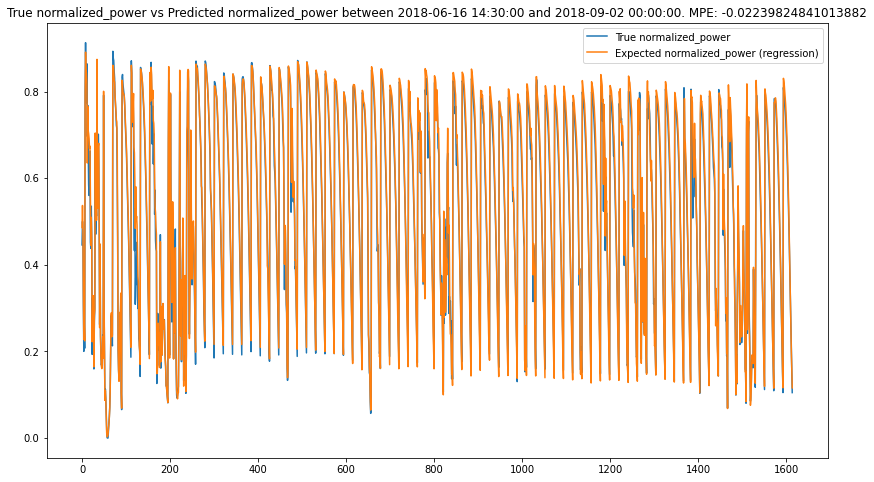

Number of rains between 2018-06-16 14:30:00 and 2018-09-02 00:00:00: 9
Max precipitation between 2018-06-16 14:30:00 and 2018-09-02 00:00:00: 0.587500025


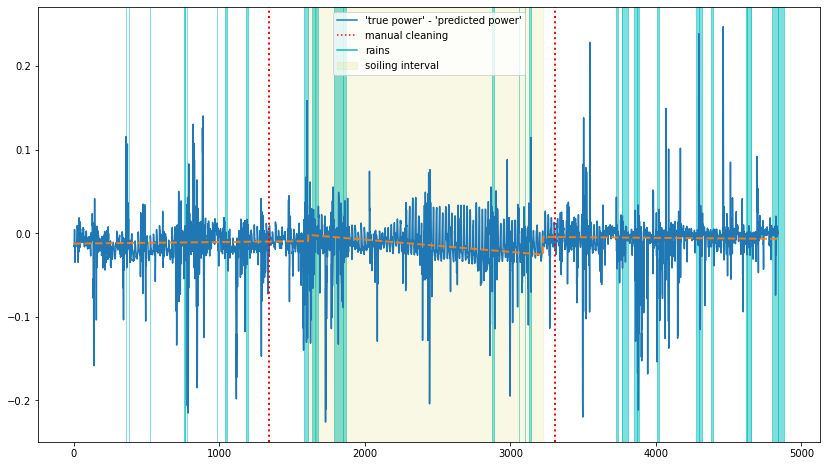

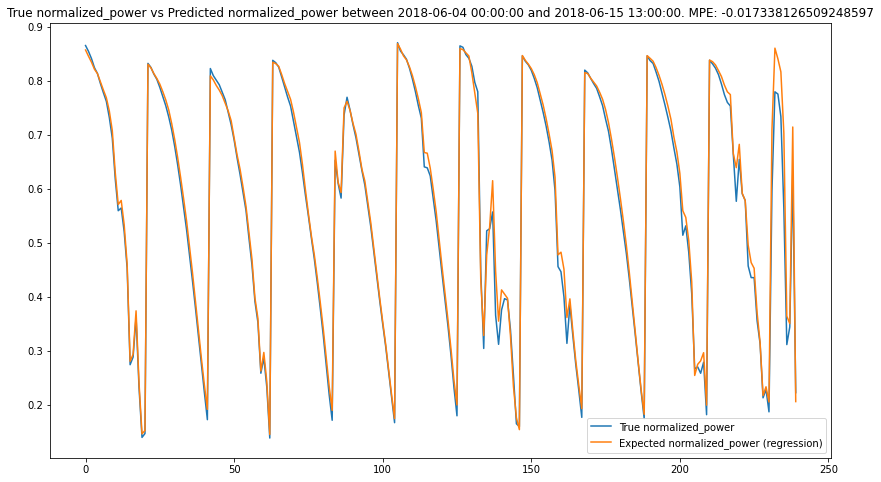

Number of rains between 2018-06-04 00:00:00 and 2018-06-15 13:00:00: 0
Max precipitation between 2018-06-04 00:00:00 and 2018-06-15 13:00:00: 0.0


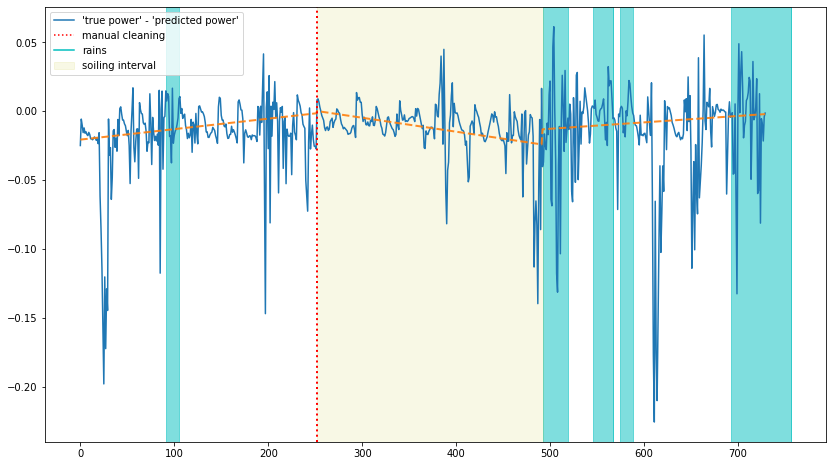

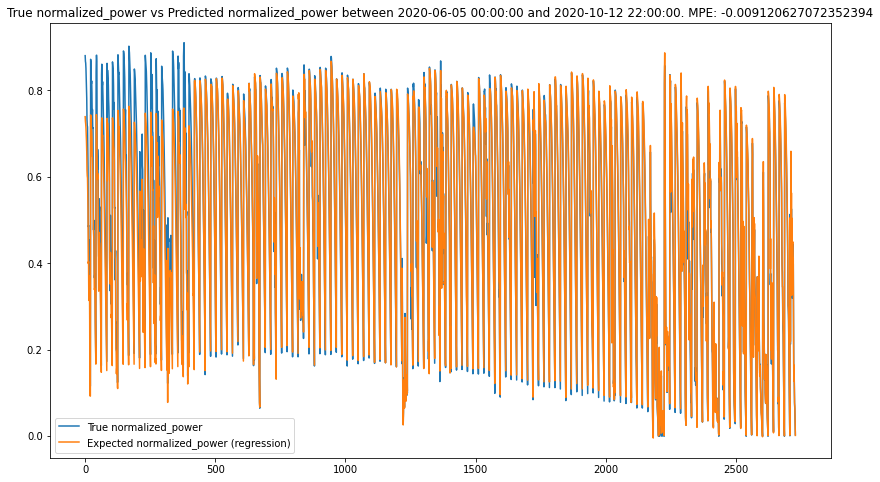

Number of rains between 2020-06-05 00:00:00 and 2020-10-12 22:00:00: 11
Max precipitation between 2020-06-05 00:00:00 and 2020-10-12 22:00:00: 2.03333883


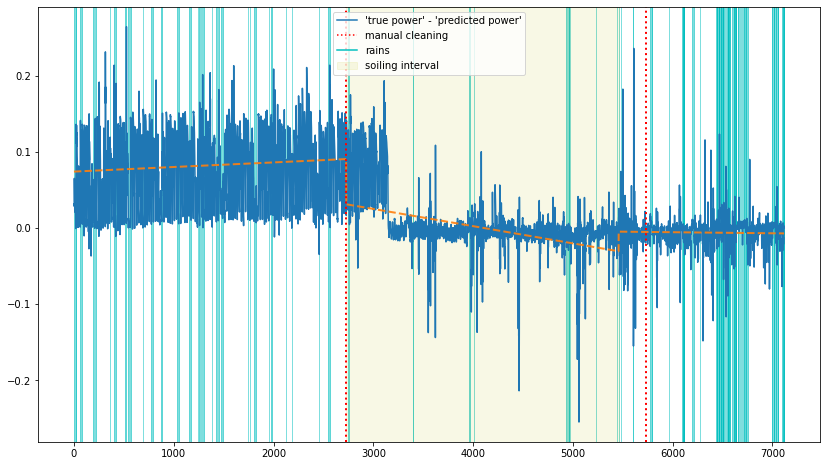

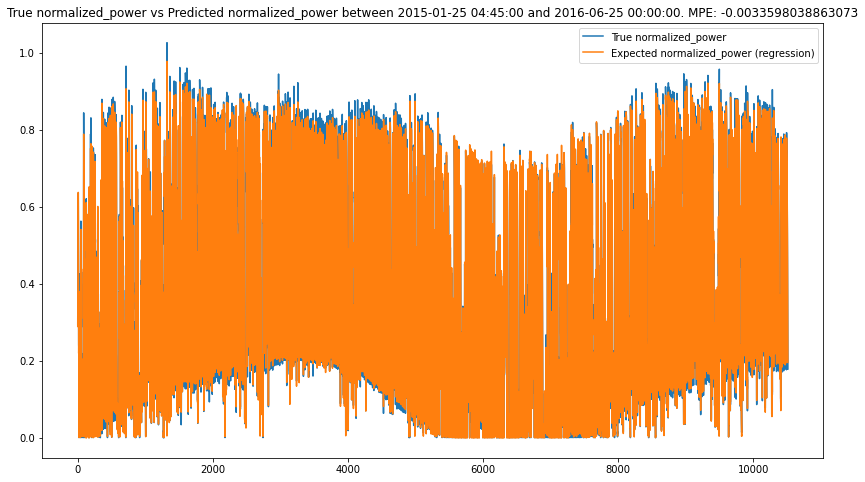

Number of rains between 2015-01-25 04:45:00 and 2016-06-25 00:00:00: 151
Max precipitation between 2015-01-25 04:45:00 and 2016-06-25 00:00:00: 21.5003586


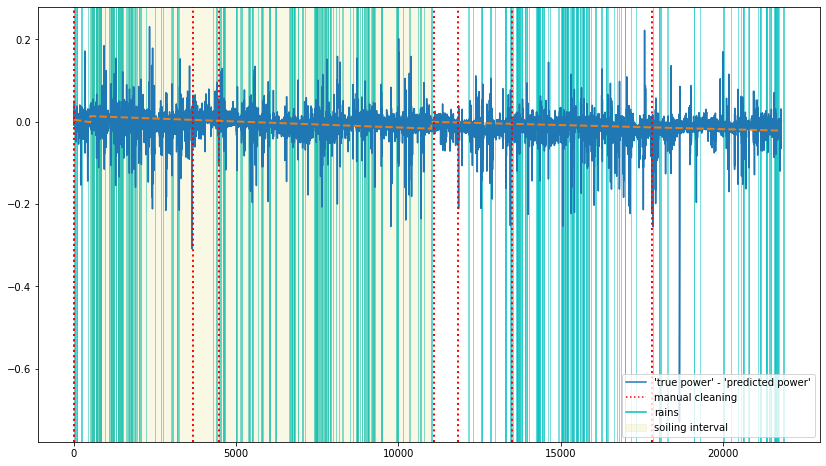

In [23]:
indices = np.argsort(np.array(mpe_scores)*(np.array(sign_slopes)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    try: 
        b2 = d1
        b1 = d1  - pd.to_timedelta(d2-d1)
    except: 
        b2 = d1
        b1 = d1    
    if slopes[j] > 0 and mpe_scores[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model1, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes[j]*mpe_scores[j])
        
        y_pred2 = predict(df_scaled.loc[d3:d4], model1, feats, target)
        y_pred0 = predict(df_scaled.loc[b1:b2], model1, feats, target)
#         diff = (df_scaled.loc[d1:d2].normalized_power - y_pred) 
#         line , slope, _ = get_ts_line_and_slope(diff.values)
        plot_segment(df_scaled, b1, b2, d1, d2, d3, d4, y_pred0, y_pred, y_pred2, mpe_scores[j], slopes[j], roll, dates_wash_start, dates_wash_stop, dates_rain_start, dates_rain_stop, precipitation)
    
                        
df_segments_output = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


In [24]:
#debugging

len(dates_rain_start)

608

### Print output

In [25]:
df_segments_output

,Score,Starting date,Ending date
0,0.022398,2018-06-16 14:30:00,2018-09-02 00:00:00
1,0.017338,2018-06-04 00:00:00,2018-06-15 13:00:00
2,0.009121,2020-06-05 00:00:00,2020-10-12 22:00:00
3,0.003360,2015-01-25 04:45:00,2016-06-25 00:00:00


### Assign scores to segments using model trained after manual cleanings
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after manual cleanings. 

In [26]:
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
slopes3 = []
mpe_scores3 = []
sign_slopes3 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        diff = (df_scaled.loc[d1:d2].normalized_power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores3.append(st.score_segment(df_scaled.loc[d1:d2].normalized_power, y_pred)[0])
        slopes3.append(-slope)
        sign_slopes3.append(np.sign(-slope))
    except:
        sign_slopes3.append(np.finfo('d').min)
        slopes3.append(np.finfo('d').min)
        mpe_scores3.append(1)

### Compute output

In [27]:
indices = np.argsort(np.array(mpe_scores3)*(np.array(sign_slopes3)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    if slopes3[j] > 0 and mpe_scores3[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes3[j]*mpe_scores3[j])
        diff = ((df_scaled.loc[d1:d2].normalized_power - y_pred))
        line , slope, _ = get_ts_line_and_slope(diff.values)
                        
df_segments_output3 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [28]:
df_segments_output3

,Score,Starting date,Ending date
0,0.020868,2018-06-16 14:30:00,2018-09-02 00:00:00
1,0.019095,2016-10-28 11:45:00,2018-02-10 10:00:00
2,0.014974,2018-06-04 00:00:00,2018-06-15 13:00:00
3,0.011350,2018-02-11 15:15:00,2018-05-31 00:00:00
4,0.006390,2020-06-05 00:00:00,2020-10-12 22:00:00


## Segmentation using changepoints obtained by Method 2

In [29]:
dates_changepoints = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp2)])
# these dates are used by the deviation detection tool
dates_start = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_stop = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_start = dates_start.union([max(df.index)])
dates_stop = dates_stop.union([min(df.index)])

### Assign scores to segments using model trained after changepoints
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after changepoints obtained by Method 2. 

In [30]:
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
slopes4 = []
mpe_scores4 = []
sign_slopes4 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model3, feats, target)
        diff = (df_scaled.loc[d1:d2].normalized_power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores4.append(st.score_segment(df_scaled.loc[d1:d2].normalized_power, y_pred)[0])
        slopes4.append(-slope)
        sign_slopes4.append(np.sign(-slope))
    except:
        sign_slopes4.append(np.finfo('d').min)
        slopes4.append(np.finfo('d').min)
        mpe_scores4.append(1)



### Compute output

In [31]:
indices = np.argsort(np.array(mpe_scores4)*(np.array(sign_slopes4)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
rain_indices = []
roll_days = 5
roll = roll_days * 20
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    if slopes4[j] > 0 and mpe_scores4[j]<0 and len(df_scaled.loc[d1:d2])>0: #and len(df_scaled.loc[d3:d4])>0:
        y_pred = predict(df_scaled.loc[d1:d2], model3, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes4[j]*mpe_scores4[j])
        
                        
df_segments_output4 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [32]:
df_segments_output4

,Score,Starting date,Ending date
0,0.000671,2015-11-28 22:00:00,2016-10-17


### Assign scores to segments using model trained after manual cleanings
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after manual cleanings.

In [33]:
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
slopes2 = []
mpe_scores2 = []
sign_slopes2 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        diff = (df_scaled.loc[d1:d2].normalized_power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores2.append(st.score_segment(df_scaled.loc[d1:d2].normalized_power, y_pred)[0])
        slopes2.append(-slope)
        sign_slopes2.append(np.sign(-slope))
    except:
        sign_slopes2.append(np.finfo('d').min)
        slopes2.append(np.finfo('d').min)
        mpe_scores2.append(1)



### Compute output

In [34]:
indices = np.argsort(np.array(mpe_scores2)*(np.array(sign_slopes2)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    if slopes2[j] > 0 and mpe_scores2[j]<0 and len(df_scaled.loc[d1:d2])>0: #and len(df_scaled.loc[d3:d4])>0:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes2[j]*mpe_scores2[j])
        diff = ((df_scaled.loc[d1:d2].normalized_power - y_pred))
        
                
df_segments_output2 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [35]:
df_segments_output2

,Score,Starting date,Ending date
0,0.028611,2016-10-21 00:00:00,2016-10-27 12:30:00
1,0.013103,2015-11-28 22:00:00,2016-10-17 00:00:00
2,0.003902,2018-09-06 00:00:00,2019-07-25 00:00:00


## Plots

### Changepoints

In [36]:
dates_changepoints1 = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp1)])
dates_changepoints2 = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp2)])

#### Method 1

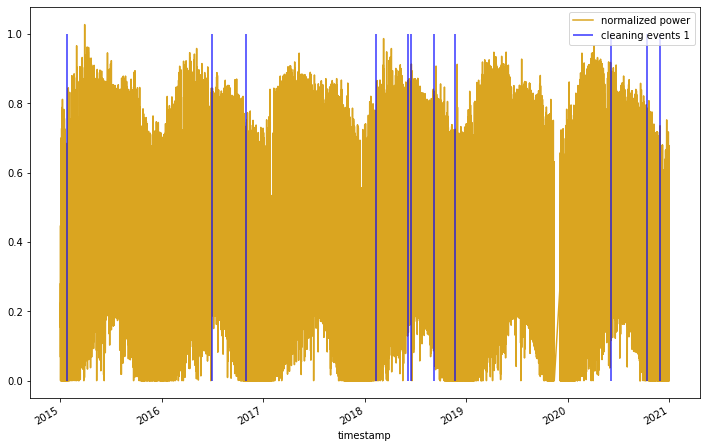

In [37]:
ymin = min(df_scaled['normalized_power'].values)
ax1 = df_scaled['normalized_power'].plot( color = 'goldenrod', label='normalized power',figsize=(12,8))
ax1.vlines(x=dates_changepoints1, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 1')

ax1.legend()
plt.show()

#### Method 2

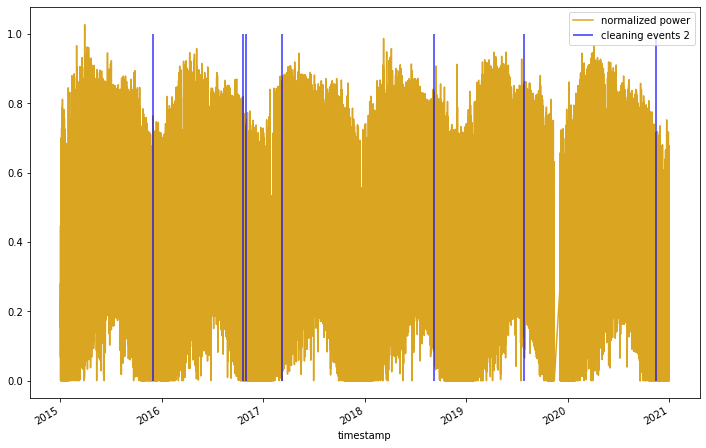

In [38]:
ymin = min(df_scaled['normalized_power'].values)
ax2 = df_scaled['normalized_power'].plot( color = 'goldenrod', label='normalized power', figsize=(12,8))
ax2.vlines(x=dates_changepoints2, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 2')
ax2.legend()
plt.show()

### Modelled soiling ratio

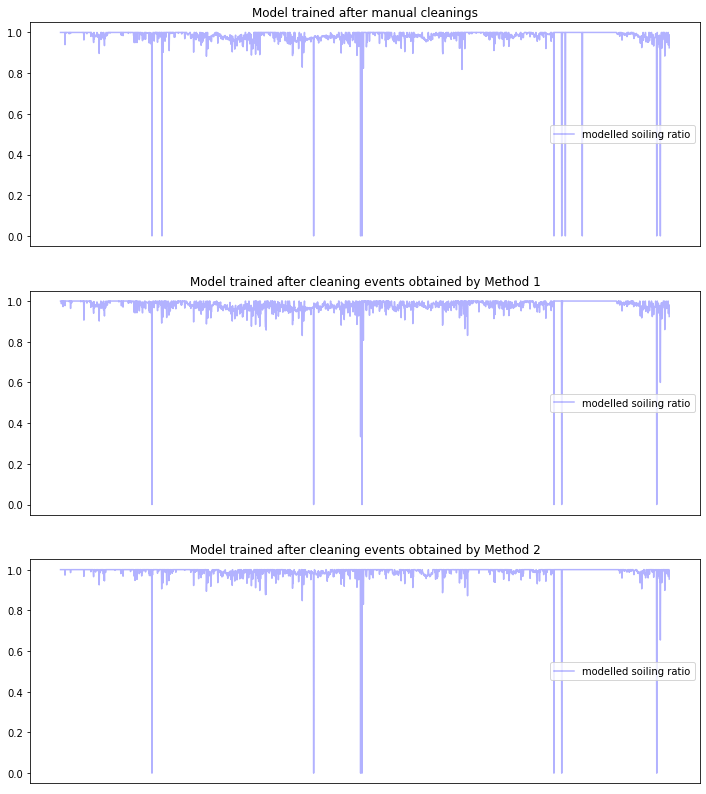

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,14))
axes = axes.ravel()


ax2 = axes[0]
ax2.set_title('Model trained after manual cleanings')
y_pred2 = predict(df_scaled, model2, feats, target)
derate2 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred2,1),0.0)
derate2 = derate2.rolling('1D', min_periods=1, center = True).median()
ax2.plot(derate2, color = 'blue', alpha = 0.3, label = 'modelled soiling ratio')
ax2.xaxis.set_visible(False)
ax2.legend()

ax1 = axes[1]
ax1.set_title('Model trained after cleaning events obtained by Method 1')
y_pred1 = predict(df_scaled, model1, feats, target)
derate1 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred1,1),0.0)
derate1 = derate1.rolling('1D', min_periods=1,center = True).median()
ax1.plot(derate1, color = 'blue', alpha = 0.3, label = 'modelled soiling ratio')
ax1.xaxis.set_visible(False)
ax1.legend()


ax3 = axes[2]
ax3.set_title('Model trained after cleaning events obtained by Method 2')
y_pred3 = predict(df_scaled, model3, feats, target)
derate3 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred3,1),0.0)
derate3 = derate3.rolling('1D', min_periods=1, center = True).median()
ax3.plot(derate3, color = 'blue', alpha = 0.3, label = 'modelled soiling ratio')
ax3.xaxis.set_visible(False)
ax3.legend()

plt.show()

### Intervals with severe soiling

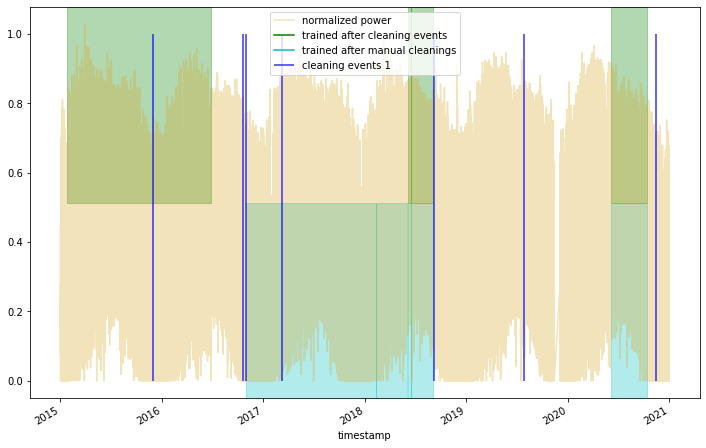

In [40]:
ymin = min(df_scaled['normalized_power'].values)
ax1 = df_scaled['normalized_power'].plot(figsize=(12,8), color = 'goldenrod',label='normalized power', alpha =0.3)
for i in range(len(df_segments_output[['Starting date']].values)):
    d1 = df_segments_output[['Starting date']].values[i][0]
    d2 = df_segments_output[['Ending date']].values[i][0]
    ax1.axvspan(d1, d2, color = 'g',ymin = 0.5, ymax=1, alpha = 0.3) 
ax1.plot([],[],label = 'trained after cleaning events',color = 'g') 
for i in range(len(df_segments_output3[['Starting date']].values)):
    d1 = df_segments_output3[['Starting date']].values[i][0]
    d2 = df_segments_output3[['Ending date']].values[i][0]
    ax1.axvspan(d1, d2, color = 'c',ymax=0.5, alpha = 0.3) 
ax1.plot([],[],label = 'trained after manual cleanings',color = 'c') 

ax1.vlines(x=dates_changepoints.values, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 1')

plt.legend()
plt.show()

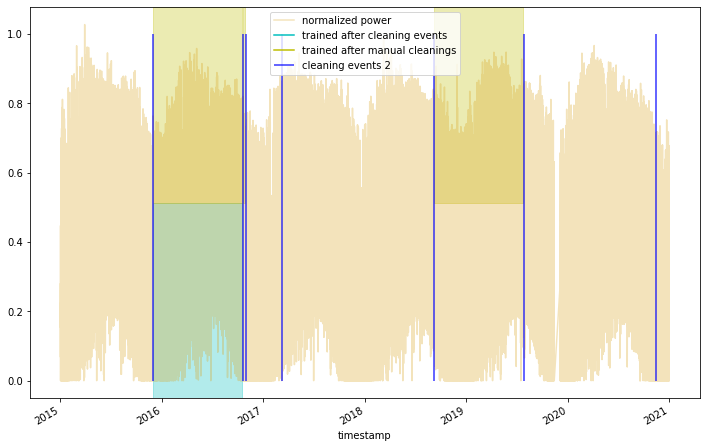

In [41]:
ymin = min(df_scaled['normalized_power'].values)
ax2 = df_scaled['normalized_power'].plot(figsize=(12,8), color = 'goldenrod',label='normalized power', alpha = 0.3)
  
for i in range(len(df_segments_output4[['Starting date']].values)):
    d1 = df_segments_output4[['Starting date']].values[i][0]
    d2 = df_segments_output4[['Ending date']].values[i][0]
    ax2.axvspan(d1, d2, color = 'c',ymax=0.5, alpha = 0.3) 
ax2.plot([],[],label = 'trained after cleaning events',color = 'c')


for i in range(len(df_segments_output2[['Starting date']].values)):
    d1 = df_segments_output2[['Starting date']].values[i][0]
    d2 = df_segments_output2[['Ending date']].values[i][0]
    ax2.axvspan(d1, d2, color = 'y', ymin=0.5, ymax=1, alpha = 0.3)  
ax2.plot([],[],label = 'trained after manual cleanings',color = 'y')    

#changepoints2
ax2.vlines(x=dates_changepoints2, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 2')
plt.legend()
plt.show()